In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from ocr.helpers import implt, resize, ratio
plt.rcParams['figure.figsize'] = (12.0, 12.0)

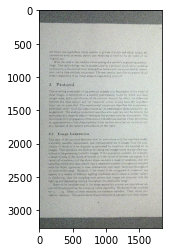

In [2]:
IMG = "check.jpg" 
image = cv2.cvtColor(cv2.imread(IMG), cv2.COLOR_BGR2RGB)
implt(image)

In [3]:
def edgesDet(img, minVal, maxVal):
    """ Preprocessing (gray, thresh, filter, border) + Canny edge detection """
    img = cv2.cvtColor(resize(img), cv2.COLOR_BGR2GRAY)
    img = cv2.bilateralFilter(img, 9, 75, 75)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 4)
    implt(img, 'gray', 'Adaptive Threshold')

    img = cv2.medianBlur(img, 11)

    img = cv2.copyMakeBorder(img, 5, 5, 5, 5, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    implt(img, 'gray', 'Median Blur + Border')

    return cv2.Canny(img, minVal, maxVal)

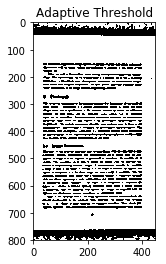

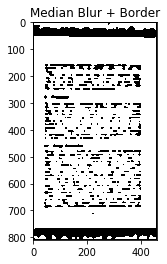

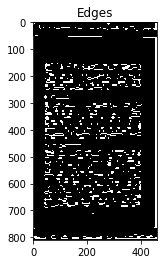

In [4]:
imageEdges = edgesDet(image, 200, 250)

closedEdges = cv2.morphologyEx(imageEdges, cv2.MORPH_CLOSE, np.ones((5, 11)))
implt(closedEdges, 'gray', 'Edges')

In [5]:
def fourCornersSort(pts):
    """ Sort corners: top-left, bot-left, bot-right, top-right"""
    diff = np.diff(pts, axis=1)
    summ = pts.sum(axis=1)
    return np.array([pts[np.argmin(summ)],
                     pts[np.argmax(diff)],
                     pts[np.argmax(summ)],
                     pts[np.argmin(diff)]])


def contourOffset(cnt, offset):
    """ Offset contour because of 5px border """
    cnt += offset
    cnt[cnt < 0] = 0
    return cnt


def findPageContours(edges, img):
    """ Finding corner points of page contour """
    # Getting contours  
    im2, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Finding biggest rectangle otherwise return original corners
    height = edges.shape[0]
    width = edges.shape[1]
    MIN_COUNTOUR_AREA = height * width * 0.5
    MAX_COUNTOUR_AREA = (width - 10) * (height - 10)

    maxArea = MIN_COUNTOUR_AREA
    pageContour = np.array([[0, 0],
                            [0, height-5],
                            [width-5, height-5],
                            [width-5, 0]])

    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)

        # Page has 4 corners and it is convex
        if (len(approx) == 4 and
                cv2.isContourConvex(approx) and
                maxArea < cv2.contourArea(approx) < MAX_COUNTOUR_AREA):
            
            maxArea = cv2.contourArea(approx)
            pageContour = approx[:, 0]

    # Sort corners and offset them
    pageContour = fourCornersSort(pageContour)
    return contourOffset(pageContour, (-5, -5))

PAGE CONTOUR:
[[  0  46]
 [  0 762]
 [454 758]
 [454  52]]


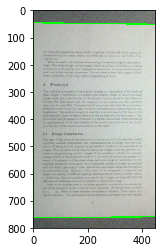

In [6]:
pageContour = findPageContours(closedEdges, resize(image))
print("PAGE CONTOUR:")
print(pageContour)
implt(cv2.drawContours(resize(image), [pageContour], -1, (0, 255, 0), 3))

pageContour = pageContour.dot(ratio(image))

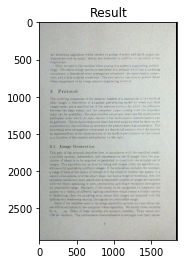

In [7]:
def perspImageTransform(img, sPoints):
    """ Transform perspective from start points to target points """
    # Euclidean distance - calculate maximum height and width
    height = max(np.linalg.norm(sPoints[0] - sPoints[1]),
                 np.linalg.norm(sPoints[2] - sPoints[3]))
    width = max(np.linalg.norm(sPoints[1] - sPoints[2]),
                 np.linalg.norm(sPoints[3] - sPoints[0]))
    
    # Create target points
    tPoints = np.array([[0, 0],
                        [0, height],
                        [width, height],
                        [width, 0]], np.float32)
    
    # getPerspectiveTransform() needs float32
    if sPoints.dtype != np.float32:
        sPoints = sPoints.astype(np.float32)
    
    M = cv2.getPerspectiveTransform(sPoints, tPoints) 
    return cv2.warpPerspective(img, M, (int(width), int(height)))
    
    
newImage = perspImageTransform(image, pageContour)
implt(newImage, t='Result')

In [8]:
# Saving cropped image
cv2.imwrite(IMG, cv2.cvtColor(newImage, cv2.COLOR_BGR2RGB))

True